In [ ]:
!pip install bayeux-ml

In [1]:
import arviz as az
import bayeux as bx
import jax
import matplotlib.pyplot as plt
import numpy as np
import numpyro


dist = numpyro.distributions

# Using bayeux with numpyro

`bayeux` has a built-in function `bx.Model.from_numpyro` that makes it easy to work with `numpyro` models.  [More on NumPyro here](https://num.pyro.ai/en/latest/index.html#)

We implement a common hierarchical model of the eight schools dataset (Rubin 1981¹), whose details can be seen on the [Stan documentation](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html), [PyMC documentation](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html), [TFP documentation](https://www.tensorflow.org/probability/examples/Eight_Schools), [numpyro documentation](https://num.pyro.ai/en/stable/getting_started.html#a-simple-example-8-schools), among others.

¹ _Rubin, Donald B. 1981. “Estimation in Parallel Randomized Experiments.” Journal of Educational and Behavioral Statistics 6 (4): 377–401._

In [2]:
num_schools = 8
treatment_effects = np.array([28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)
treatment_stddevs = np.array([15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)

def numpyro_model():
  avg_effect = numpyro.sample('avg_effect', dist.Normal(0., 10.))
  avg_stddev = numpyro.sample('avg_stddev', dist.HalfNormal(10.))
  with numpyro.plate('J', 8):
    school_effects = numpyro.sample('school_effects', dist.Normal(0., 1.))
    numpyro.sample('observed',
                   dist.Normal(avg_effect[..., None] + avg_stddev[..., None] * school_effects,
                               treatment_stddevs),
                   obs=treatment_effects)

bx_model = bx.Model.from_numpyro(numpyro_model)

In [3]:
idata = bx_model.mcmc.blackjax_nuts(seed=jax.random.key(0))

az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg_effect,6.498,4.225,-1.617,14.281,0.072,0.053,3499.0,2559.0,1.0
avg_stddev,4.588,3.638,0.002,11.262,0.075,0.053,1877.0,1610.0,1.0
school_effects[0],0.342,0.962,-1.430,2.219,0.016,0.014,3832.0,2866.0,1.0
school_effects[1],0.048,0.917,-1.720,1.753,0.015,0.015,3568.0,2978.0,1.0
school_effects[2],-0.164,0.949,-1.869,1.702,0.014,0.016,4428.0,2716.0,1.0
school_effects[3],0.016,0.909,-1.744,1.697,0.013,0.014,4546.0,3120.0,1.0
school_effects[4],-0.259,0.929,-1.957,1.497,0.016,0.014,3436.0,2951.0,1.0
school_effects[5],-0.143,0.928,-1.878,1.597,0.014,0.015,4132.0,2834.0,1.0
school_effects[6],0.337,0.935,-1.513,1.993,0.015,0.014,3757.0,3180.0,1.0
school_effects[7],0.070,0.982,-1.797,1.901,0.016,0.016,3929.0,2696.0,1.0


{'avg_effect': Array([6.170515 , 6.170513 , 6.170513 , 6.1705136, 6.1705155, 6.1705165,
        6.170514 , 6.1705165], dtype=float32),
 'avg_stddev': Array([10.625167 , 10.625165 , 10.625165 , 10.6250305, 10.625165 ,
        10.625165 , 10.625165 , 10.625165 ], dtype=float32),
 'school_effects': Array([[ 0.68643355,  0.09130633, -0.26413605,  0.0376812 , -0.3929353 ,
         -0.23488224,  0.5903885 ,  0.14177176],
        [ 0.6864336 ,  0.09130642, -0.264136  ,  0.03768136, -0.39293545,
         -0.23488215,  0.59038854,  0.1417718 ],
        [ 0.6864337 ,  0.09130641, -0.26413602,  0.03768132, -0.39293548,
         -0.23488215,  0.5903885 ,  0.14177178],
        [ 0.68643266,  0.0913064 , -0.2653734 ,  0.03768122, -0.39293522,
         -0.23488234,  0.5903885 ,  0.14177188],
        [ 0.68643355,  0.0913063 , -0.26413605,  0.03768115, -0.39293563,
         -0.23488225,  0.5903884 ,  0.14177172],
        [ 0.68643355,  0.09130625, -0.26413608,  0.03768115, -0.39293572,
         -0.234

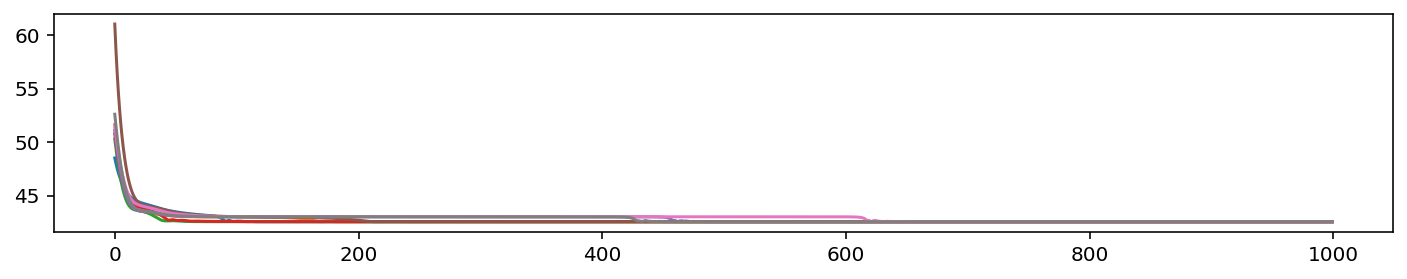

In [4]:
opt_results = bx_model.optimize.optax_adam(seed=jax.random.PRNGKey(0))


fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(opt_results.loss.T)
opt_results.params

{'avg_effect': Array(6.4629807, dtype=float32),
 'avg_stddev': Array(3.9471092, dtype=float32),
 'school_effects': Array([ 0.36255646,  0.05804498, -0.17273399, -0.01884749, -0.21912189,
        -0.16507226,  0.3044645 ,  0.06365629], dtype=float32)}

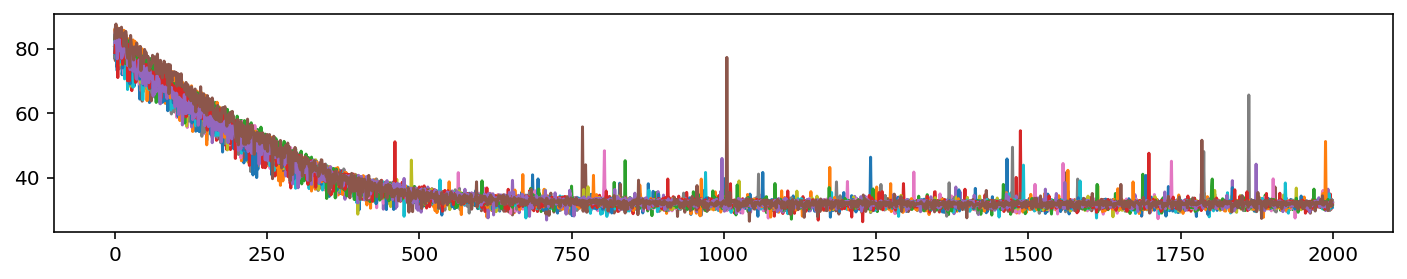

In [6]:
surrogate_posterior, losses = bx_model.vi.tfp_factored_surrogate_posterior(
    seed=jax.random.PRNGKey(0))


fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(losses.T)

draws = surrogate_posterior.sample(100, seed=jax.random.PRNGKey(1))
jax.tree.map(lambda x: np.mean(x, axis=(0, 1)), draws)